# Recommendation with Explict Feedback

In this notebook we demostrate how to build neural network recommendation system with explict feedback. The system ([Recommendation systems: Principles, methods and evaluation](http://www.sciencedirect.com/science/article/pii/S1110866515000341)) normally prompts the user through the system interface to provide ratings for items in order to construct and improve his model. The accuracy of recommendation depends on the quantity of ratings provided by the user.  

Data: 
* The dataset we used is movielens-1M ([link](https://grouplens.org/datasets/movielens/1m/)), which contains 1 million ratings from 6000 users on 4000 movies.  There're 5 levels of rating. We will try classify each (user,movie) pair into 5 classes and evaluate the effect of algortithms using Mean Absolute Error.  
  
References: 
* A Keras implementation of Movie Recommendation([notebook](https://github.com/ririw/ririw.github.io/blob/master/assets/Recommending%20movies.ipynb)) from the [blog](http://blog.richardweiss.org/2016/09/25/movie-embeddings.html).
* Nerual Collaborative filtering ([He, 2015](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf))

## Intialization

* import necesary 3rd party libraries

In [1]:
import matplotlib.pyplot as plt
from sklearn import metrics
import datetime as dt
from operator import itemgetter

%matplotlib inline

* import necessary modules

In [2]:
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.dataset import movielens

* initilaize BigDL

In [3]:
init_engine()

## Data Preparation

* Read movielens 1M data using provided utiltiy in BigDL 


In [4]:
movielens_data = movielens.get_id_ratings("/tmp/movielens/")	

('Downloading data from', 'http://files.grouplens.org/datasets/movielens/ml-1m.zip')
5857280/5917549 [============================>.] - ETA: 0s('Successfully downloaded', 'ml-1m.zip', 5917549, 'bytes.')
Extracting /tmp/movielens/ml-1m.zip to /tmp/movielens/


* Understand the data.

Each record is in format of (userid, movieid, rating_score). UserIDs range between 1 and 6040. MovieIDs range between 1 and 3952. Ratings are made on a 5-star scale (whole-star ratings only). Counts of users and movies are recorded for later use.

In [5]:
min_user_id = np.min(movielens_data[:,0])
max_user_id = np.max(movielens_data[:,0])
min_movie_id = np.min(movielens_data[:,1])
max_movie_id = np.max(movielens_data[:,1])
rating_labels= np.unique(movielens_data[:,2])

print movielens_data.shape
print min_user_id, max_user_id, min_movie_id, max_movie_id, rating_labels

(1000209, 3)
1 6040 1 3952 [1 2 3 4 5]


* Transform original data into RDD
BigDL requires train data and validation data to be provided in format of RDD([Sample](https://bigdl-project.github.io/master/#APIGuide/Data/#sample)). A `Sample` is a BigDL data structure which can be constructed using 2 numpy arrays, `feature` and `label` respectively. The API interface is `Sample.from_ndarray(feature, label)`

In [6]:
#convert ndarray data into RDD[Sample]
def array2rdd(arr):
    #build Sample from ndarrays
    def build_sample(userid,movieid,rating):
        feature = np.array([userid, movieid]).flatten()
        label = np.array(rating)
        return Sample.from_ndarray(feature, label)
    rdd = sc.parallelize(arr).map(lambda (uid, mid,rating): build_sample(uid, mid,rating))
    return rdd

movielens_rdd = array2rdd(movielens_data)
movielens_rdd.cache()

PythonRDD[1] at RDD at PythonRDD.scala:48

* Randomly split the data into train (80%) and validation (20%)

In [7]:
train_rdd, val_rdd = movielens_rdd.randomSplit([0.8, 0.2], seed= 1L)

In [8]:
print train_rdd.count(), val_rdd.count()

799925 200284


## Build Model

* Here we show an example of building a Multi-Layer Perceptron (MLP) using BigDL functional API. 
The buttom layer is input layer. Then it is embedding layer, which projects the sparse representation to a dense vector. The user (item) embedding can be seen as the latent vector for user (item). In BigDL, we can use LookUpTable together with Select to create embedding layers. At last, embedding layers are fed into a multi-layer neural architecture. Please refer to([BigDL programming guide](https://bigdl-project.github.io/master/#ProgrammingGuide/Model/Functional/)) for more details about functional API, and Nerual Collaborative filtering ([He, 2015](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf)) for details about the architeture. 

In [9]:
def build_model(num_users, num_items, layers=[20, 10]):
    input = Identity()()
    select_1 = Select(2, 1)(input)
    select_2 = Select(2, 2)(input)
    user_table = LookupTable(num_users, layers[0] / 2)(select_1)
    item_table = LookupTable(num_items, layers[0] / 2)(select_2)

    embedded_layer = JoinTable(2,0)([user_table, item_table])

    relu_layer = embedded_layer
    for idx in xrange(1, len(layers)):
        linear_layer = Linear(layers[idx - 1], layers[idx])(relu_layer)
        relu_layer = ReLU()(linear_layer)

    linear_last = Linear(layers[-1], 5)(relu_layer)
    output = LogSoftMax()(linear_last)

    model = Model([input], [output])

    return model

In [10]:
model = build_model(max_user_id, max_movie_id)

creating: createIdentity
creating: createSelect
creating: createSelect
creating: createLookupTable
creating: createLookupTable
creating: createJoinTable
creating: createLinear
creating: createReLU
creating: createLinear
creating: createLogSoftMax
creating: createModel


## Setup the Optimizer

- In BigDL, you want to create an optimizer and then call optimizer.optimize to train a model.
Optimizer tries to minimize the loss of the neural net with respect to its weights/biases, over the training set. To create an Optimizer in BigDL, you want to at least specify arguments: model(a neural network model), criterion(the loss function), traing_rdd(training dataset) and batch size. Please refer to ([ProgrammingGuide](https://bigdl-project.github.io/master/#ProgrammingGuide/optimization/))and ([Optimizer](https://bigdl-project.github.io/master/#APIGuide/Optimizers/Optimizer/)) for more details to create efficient optimizers.

In [11]:
optimizer = Optimizer(
    model=model,
    training_rdd=train_rdd,
    criterion=ClassNLLCriterion(),
    end_trigger=MaxEpoch(20),
    batch_size=2800,
    optim_method=Adam(learningrate=0.001))

optimizer.set_validation(
    batch_size=2800,
    val_rdd=val_rdd,
    trigger=EveryEpoch(),
    val_method=[MAE(), Loss(ClassNLLCriterion())]
)

creating: createClassNLLCriterion
creating: createMaxEpoch
creating: createAdam
creating: createOptimizer
creating: createEveryEpoch
creating: createMAE
creating: createClassNLLCriterion
creating: createLoss


## Collect logs

* In BigDL, TrainSummary and ValidationSummary are logs which allow user to trace how indicators (e.g. learning rate, training loss, throughput, etc.) change with iterations/time in an optimization process.

A function of config_summaries is defined to collect monitoring data during training and validation phases.

In [12]:
def config_summaries(optimizer):
    """
    :param: optimizer: the optimizer created in start_train()
    """
    app_name = 'recommender-' + dt.datetime.now().strftime("%Y%m%d-%H%M%S")

    # train summary
    train_summary = TrainSummary(log_dir="./log", app_name=app_name)
    train_summary.set_summary_trigger("Loss", SeveralIteration(1))
    optimizer.set_train_summary(train_summary)

    # validation summary
    val_summary = ValidationSummary(log_dir="./log", app_name=app_name)
    optimizer.set_val_summary(val_summary)

    print "saving logs to ./log/" + app_name
    return train_summary, val_summary

train_summary, val_summary = config_summaries(optimizer)

creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to ./log/recommender-20171025-220741


## Train the model

In [13]:
trained_model = optimizer.optimize()

## Prediction

* BigDL models make inferences based on the given data using model.predict(val_rdd) API. A result of RDD is returned. predict_class returns the predicted label. 
* Example of use case: given some users and movies, we can recommend  a list of movies(here topK =3) for the users. We use user ids and movie ids from validation data set as example to show the recommendation.  
* uidTopKMovies is defined as a list of key value pairs, where key is user id, value is a list of topK movie id and predicted label(rating). For example, print uidTopKMovies[0:3] will give [(4.0, [[1198.0, 5], [2692.0, 5], [480.0, 4]]), (8.0, [[150.0, 5], [555.0, 5], [2396.0, 5]]), (12.0, [[1193.0, 5], [593.0, 5], [919.0, 5]])]

In [14]:
res = trained_model.predict(val_rdd).collect()
predicted_labels = np.argmax(np.asarray(res),1)+1
print predicted_labels[0:10]

topK = 3
uidMid = val_rdd.map(lambda x: x.features)
predicted_labels = trained_model.predict_class(val_rdd)

uidTopKMovies = uidMid \
    .zip(predicted_labels) \
    .map(lambda x: (x[0][0].storage[0], [x[0][0].storage[1], x[1]])) \
    .groupByKey() \
    .map(lambda x: (x[0], sorted(list(x[1]), key=itemgetter(1), reverse=True)[0:topK])).collect()

print(uidTopKMovies[0:3])

[5 5 4 4 4 4 4 4 5 4]
[(4.0, [[480.0, 5], [1198.0, 5], [3702.0, 5]]), (8.0, [[150.0, 5], [17.0, 5], [555.0, 5]]), (12.0, [[1193.0, 5], [593.0, 5], [919.0, 5]])]


## Evaluation

* plot the train and validation loss curves

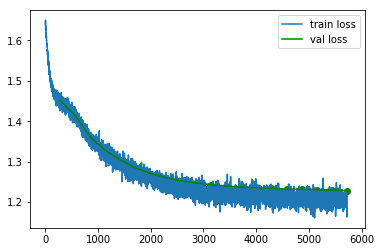

In [15]:
#retrieve train and validation summary object and read the loss data into ndarray's. 
loss = np.array(train_summary.read_scalar("Loss"))
val_loss  = np.array(val_summary.read_scalar("Loss"))

#plot the train and validation curves
# each event data is a tuple in form of (iteration_count, value, timestamp)
plt.plot(loss[:,0],loss[:,1],label='train loss')
plt.plot(val_loss[:,0],val_loss[:,1],label='val loss',color='green')
plt.scatter(val_loss[:,0],val_loss[:,1],color='green')
plt.legend();

* plot the MAE curve during validation

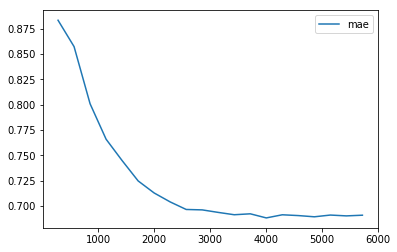

In [16]:
#retrieve train and validation summary object and read the loss data into ndarray's. 
val_mae  = np.array(val_summary.read_scalar("MAE"))

#plot the train and validation curves
# each event data is a tuple in form of (iteration_count, value, timestamp)
plt.plot(val_mae[:,0],val_mae[:,1],label='mae')
plt.legend();

* output the final MAE on validation dataset using BigDL API

In [17]:
res2 = trained_model.evaluate(val_rdd,2800,[MAE()])

creating: createMAE


In [18]:
'\n'.join([str(r) for r in res2])

'Evaluated result: 0.691401600838, total_num: 287, method: MAE'